#Imports


In [ ]:
# Import required modules

import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')
stop = stopwords.words('english')

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation, BatchNormalization, SpatialDropout1D, CuDNNLSTM
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Import Data

from google.colab import drive
drive.mount('/content/drive')

# Change PATH to folder
DATA_PATH = "drive/MyDrive/nlp_project/"

train = pd.read_csv(DATA_PATH + "train.csv")
test = pd.read_csv(DATA_PATH + "test.csv")
test_labels = pd.read_csv(DATA_PATH + "test_labels.csv")

Mounted at /content/drive


# Dataset Exploration

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# Example comment

train["comment_text"].values[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
print("Trining data shape:", train.shape)
print("Testing data shape:",test.shape)

Trining data shape: (159571, 8)
Testing data shape: (153164, 2)


In [ ]:
# Check for NaNs in the training data

train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [ ]:
# Check for NaNs in the testing data

test.isnull().any()

id              False
comment_text    False
dtype: bool

Merging Test Files and Removing rows with -1 labels

In [ ]:
# Merge test data with test labels and drop all rows with label as -1

concatenated_test = pd.merge(test, test_labels)
concat_cols = concatenated_test[ (concatenated_test['toxic'] == -1) & (concatenated_test['severe_toxic'] == -1) & (concatenated_test['obscene'] == -1) & (concatenated_test['threat'] == -1) & (concatenated_test['insult'] == -1) & (concatenated_test['identity_hate'] == -1)].index
test = concatenated_test.drop(concat_cols, inplace = False)
test.drop(['id'], inplace = True, axis = 1)

test_y = test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()

# Data Preprocessing

Declaring Punctuations Bank

In [ ]:
punctuations = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

Method to Removing Numbers

In [ ]:
def number_cleaning(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

Method to clean text of punctuations

In [ ]:
def text_cleaning(x):
    x = str(x).lower()
    for punctuation in punctuations:
        if punctuation in x:
            x = x.replace(punctuation, '')
    return x

In [ ]:
# Applying the preprocessing functions on both training and testing set

train['comment_text'] = train['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train['comment_text'] = train['comment_text'].apply(text_cleaning)
train['comment_text'] = train['comment_text'].apply(number_cleaning)

test['comment_text'] = test['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['comment_text'] = test['comment_text'].apply(text_cleaning)
test['comment_text'] = test['comment_text'].apply(number_cleaning)

# Baseline Model


Using TF-IDF for word/sentence embedding

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=9000, ngram_range=(1,2))
train_X = tfidf_vectorizer.fit_transform(train['comment_text'])
test_X = tfidf_vectorizer.fit_transform(test['comment_text'])

Model Building & Training - Logistic Regression


In [ ]:
logistic_toxic = LogisticRegression(random_state=0)
logistic_toxic.fit(train_X,train['toxic'])

LogisticRegression(random_state=0)

In [ ]:
logistic_severetoxic = LogisticRegression(random_state=0)
logistic_severetoxic.fit(train_X, train['severe_toxic'])

LogisticRegression(random_state=0)

In [ ]:
logistic_obscene = LogisticRegression(random_state=0)
logistic_obscene.fit(train_X, train['obscene'])

LogisticRegression(random_state=0)

In [ ]:
logistic_threat = LogisticRegression(random_state=0)
logistic_threat.fit(train_X, train['threat'])

LogisticRegression(random_state=0)

In [ ]:
logistic_insult = LogisticRegression(random_state=0)
logistic_insult.fit(train_X, train['insult'])

LogisticRegression(random_state=0)

In [ ]:
logistic_identityhate = LogisticRegression(random_state=0)
logistic_identityhate.fit(train_X, train['identity_hate'])

LogisticRegression(random_state=0)

Model Evaluation

In [ ]:
logistic_toxic_predicted = logistic_toxic.predict(test_X)
logistic_severetoxic_predicted = logistic_severetoxic.predict(test_X)
logistic_obscene_predicted = logistic_obscene.predict(test_X)
logistic_threat_predicted = logistic_threat.predict(test_X)
logistic_insult_predicted = logistic_insult.predict(test_X)
logistic_identityhate_predicted = logistic_identityhate.predict(test_X)

stk1 = np.column_stack((logistic_toxic_predicted,logistic_severetoxic_predicted))
stk2 = np.column_stack((stk1, logistic_obscene_predicted))
stk3 = np.column_stack((stk2, logistic_threat_predicted))
stk4 = np.column_stack((stk3, logistic_insult_predicted))
stk5 = np.column_stack((stk4, logistic_identityhate_predicted))

Baseline Metrics

In [ ]:
logistic_accuracy = metrics.accuracy_score(test_y, stk5)
logistic_precision = metrics.precision_score(test_y, stk5, average='macro')
logistic_f1score = metrics.f1_score(test_y, stk5, average='macro')
logistic_recall = metrics.recall_score(test_y, stk5, average='macro')

print("Accuracy:", logistic_accuracy)
print("Precision:", logistic_precision)
print("Recall:", logistic_recall)
print("F1 Score:", logistic_f1score)

Accuracy: 0.895589108756135
Precision: 0.03573210963982707
Recall: 0.001642134665125069
F1 Score: 0.0031046445885034826


# Proposed Models

In [ ]:
# Helper Function

def print_graph(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])

  plt.title('model accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')

  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')

  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def convertToBinary(x):
  if x >= 0.5:
    return 1
  else:
    return 0

## Model 1 - Keras Inbuilt Embedding + Single Layer LSTM
## Model 2 - Keras Inbuilt Embedding + Single Layer Bidirectional LSTM

In [ ]:
tokenizer = Tokenizer(num_words=20000) #maximum features

tokenizer.fit_on_texts(list(train['comment_text']))

train_x_tokenized = tokenizer.texts_to_sequences(train["comment_text"])
test_x_tokenized = tokenizer.texts_to_sequences(test["comment_text"])

In [ ]:
train_X = pad_sequences(train_x_tokenized, maxlen=200)
test_X = pad_sequences(test_x_tokenized, maxlen=200)

labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_Y = train[labels].copy().to_numpy()
test_Y = test_y.to_numpy()

In [ ]:
#Embedding Parameters
maximum_features = 20000
embedding_size = 128

Keras Inbuilt Embedding + Single Layer LSTM

In [ ]:
def lstm_model_structure():
  model = Sequential()
  model.add(Embedding(maximum_features, embedding_size))
  model.add(LSTM(60, return_sequences=True,name='lstm_layer'))
  model.add(GlobalMaxPool1D())
  model.add(Dropout(0.1))
  model.add(Dense(50, activation="relu"))
  model.add(Dropout(0.1))
  model.add(Dense(6, activation="sigmoid"))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])	

  return model

In [ ]:
lstm_model = lstm_model_structure()
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_layer (LSTM)           (None, None, 60)          45360     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                        

In [ ]:
history_lstm_model = lstm_model.fit(train_X,train_Y, batch_size=32, epochs=2, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 205s 45ms/step - loss: 0.0706 - accuracy: 0.9561 - val_loss: 0.0524 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 201s 45ms/step - loss: 0.0450 - accuracy: 0.9863 - val_loss: 0.0488 - val_accuracy: 0.9939


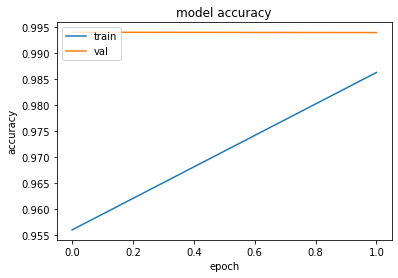

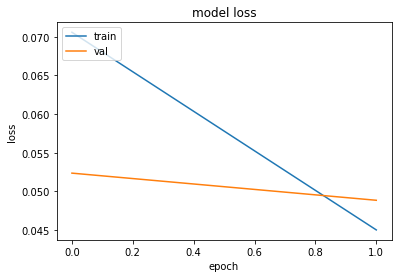

In [ ]:
print_graph(history_lstm_model)

In [ ]:
lstm_predicted = lstm_model.predict(test_X)

In [ ]:
vector_func = np.vectorize(convertToBinary)

In [ ]:
metrics.accuracy_score(test_Y, vector_func(lstm_predicted))

0.86951764669105

Keras Inbuilt Embedding + Single Layer Bidirectional LSTM

In [ ]:
def bidirectional_model_structure():
  model = Sequential()
  model.add(Embedding(maximum_features, embedding_size))
  model.add(Bidirectional(LSTM(60, return_sequences=True,name='bidirectional_lstm_layer')))
  model.add(GlobalMaxPool1D())
  model.add(Dropout(0.1))
  model.add(Dense(50, activation="relu"))
  model.add(Dropout(0.1))
  model.add(Dense(6, activation="sigmoid"))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])	

  return model

In [ ]:
bidirectional_lstm_model = bidirectional_model_structure()
bidirectional_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         2560000   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 120)        90720     
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 120)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 120)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                6050      
                                                                 
 dropout_4 (Dropout)         (None, 50)               

In [ ]:
history_bidirectional_lstm_model = bidirectional_lstm_model.fit(train_X,train_Y, batch_size=32, epochs=2, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 396s 87ms/step - loss: 0.0634 - accuracy: 0.9418 - val_loss: 0.0508 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 390s 87ms/step - loss: 0.0453 - accuracy: 0.9743 - val_loss: 0.0495 - val_accuracy: 0.9913


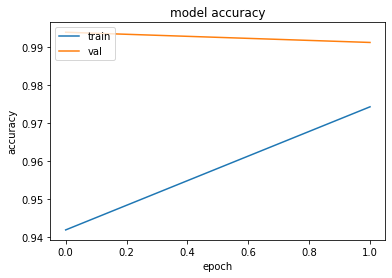

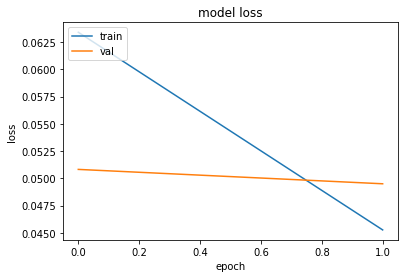

In [ ]:
print_graph(history_bidirectional_lstm_model)

In [ ]:
bidirectional_lstm_predicted = bidirectional_lstm_model.predict(test_X)

In [ ]:
metrics.accuracy_score(test_Y, vector_func(bidirectional_lstm_predicted))

0.8825690080965332

## Model 3 - Glove Embedding + Bidirectional LSTM

In [ ]:
# Load GloVe Embeddings

def load_glove_index():
    EMBEDDING_FILE = DATA_PATH + 'glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    return embeddings_index

embeddings_index = load_glove_index()

In [ ]:
print("Words in GloVe: ", len(embeddings_index))

Words in GloVe:  2196017


In [ ]:
embed_size = 300
max_features = 20000
maxlen = 100

In [ ]:
X_train = pad_sequences(train_x_tokenized, maxlen=maxlen)
X_test = pad_sequences(test_x_tokenized, maxlen=maxlen)
y_train = train_Y
y_test = test_Y

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(-0.005838503, 0.48782194)

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector


In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
x = Bidirectional(LSTM(50, return_sequences=True,dropout=0.1, recurrent_dropout=0.1))(x)
x = Bidirectional(LSTM(50, return_sequences=True,dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(50, activation="relu")(x)
#x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

import keras.backend as K
def loss(y_true, y_pred):
     return K.binary_crossentropy(y_true, y_pred)
    
model.compile(loss=loss, optimizer='nadam', metrics=['accuracy'])


In [ ]:
def schedule(ind):
    a = [0.002,0.003, 0.01]
    return a[ind]
lr = callbacks.LearningRateScheduler(schedule)

import tensorflow as tf
y_train = tf.cast(y_train, tf.float32)
history = model.fit(X_train, y_train, batch_size=256,validation_split=0.2, epochs=3, callbacks=[lr])

Epoch 1/3
499/499 [==============================] - 1277s 3s/step - loss: 0.0788 - accuracy: 0.6634 - val_loss: 0.0533 - val_accuracy: 0.7363 - lr: 0.0020
Epoch 2/3
499/499 [==============================] - 1279s 3s/step - loss: 0.0461 - accuracy: 0.8124 - val_loss: 0.0463 - val_accuracy: 0.9375 - lr: 0.0030
Epoch 3/3
499/499 [==============================] - 1269s 3s/step - loss: 0.0448 - accuracy: 0.8686 - val_loss: 0.0496 - val_accuracy: 0.9889 - lr: 0.0100


In [ ]:
model.save(DATA_PATH + "glove_bilstm")

INFO:tensorflow:Assets written to: drive/MyDrive/nlp_project/glove_bilstm2/assets


In [ ]:
model_load = keras.models.load_model(DATA_PATH + "glove_bilstm", custom_objects={"loss":loss})

In [ ]:
y_test = tf.cast(y_test, tf.float32)
model_load.evaluate(X_test, y_test, batch_size=256)

250/250 [==============================] - 46s 179ms/step - loss: 0.0721 - accuracy: 0.9486


[0.07214516401290894, 0.948607325553894]

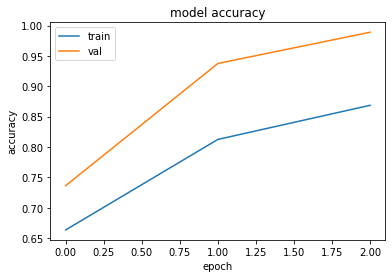

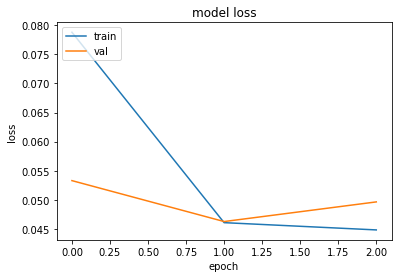

In [ ]:
print_graph(history)